# データの学習
※Google Colab で実行

In [ ]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [2]:
# npyファイル読み込み
X_train = np.load('/content/drive/MyDrive/python/chest_xray/X_train2.npy')
Y_train = np.load('/content/drive/MyDrive/python/chest_xray/Y_train2.npy')
X_train = X_train.astype(np.float32)
X_train = X_train / 255.0

X_valid = np.load('/content/drive/MyDrive/python/chest_xray/X_valid2.npy')
Y_valid = np.load('/content/drive/MyDrive/python/chest_xray/Y_valid2.npy')
X_valid = X_valid.astype(np.float32)
X_valid = X_valid / 255.0

In [3]:
# XとYの対応関係を保ったままシャッフル
seed_train = np.random.permutation(len(X_train))
X_train = X_train[seed_train]
Y_train = Y_train[seed_train]
seed_valid = np.random.permutation(len(X_valid))
X_valid = X_valid[seed_valid]
Y_valid = Y_valid[seed_valid]

In [4]:
# データの拡張
datagen = ImageDataGenerator(
        rotation_range=20, 
        zoom_range=0.15, 
        width_shift_range=0.15, 
        height_shift_range=0.15, 
        )

In [6]:
# モデルの定義(VGG16)
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# model.summary()

# ファインチューニング
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

model = Model(inputs=model.input, outputs=top_model(model.output))

model.summary()

for layer in model.layers[:15]:
    layer.trainable = False

# 学習率のスケジューリング
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)

opt = RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# 学習の実施
batch_size_train = 128
batch_size_valid = 32
epochs = 40
log = model.fit(
    datagen.flow(X_train, Y_train, batch_size_train),
    steps_per_epoch=len(X_train) // batch_size_train,
    epochs=epochs,
    verbose=True,
    validation_data=datagen.flow(X_valid, Y_valid, batch_size=batch_size_valid),
    validation_steps=len(X_valid) // batch_size_valid,
    callbacks=[callback],  
    )

Epoch 1/40
32/32 [==============================] - 60s 1s/step - loss: 0.5158 - accuracy: 0.8035 - val_loss: 0.1922 - val_accuracy: 0.9209
Epoch 2/40
32/32 [==============================] - 50s 2s/step - loss: 0.2407 - accuracy: 0.9004 - val_loss: 0.1853 - val_accuracy: 0.9141
Epoch 3/40
32/32 [==============================] - 50s 2s/step - loss: 0.1991 - accuracy: 0.9228 - val_loss: 0.1258 - val_accuracy: 0.9570
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.1803 - accuracy: 0.9256 - val_loss: 0.1625 - val_accuracy: 0.9268
Epoch 5/40
32/32 [==============================] - 49s 2s/step - loss: 0.1414 - accuracy: 0.9465 - val_loss: 0.1408 - val_accuracy: 0.9473
Epoch 6/40
32/32 [==============================] - 49s 2s/step - loss: 0.1309 - accuracy: 0.9477 - val_loss: 0.0855 - val_accuracy: 0.9697
Epoch 7/40
32/32 [==============================] - 48s 2s/step - loss: 0.1305 - accuracy: 0.9482 - val_loss: 0.1038 - val_accuracy: 0.9609
Epoch 8/40
32/32 [==

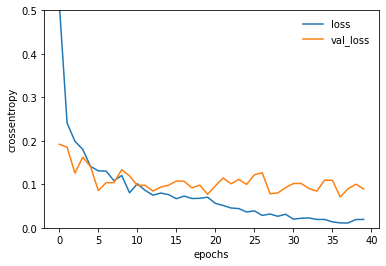

In [8]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.ylim(0.0, 0.5)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [9]:
# npyファイル読み込み
X_test = np.load('/content/drive/MyDrive/python/chest_xray/X_test2.npy')
Y_test = np.load('/content/drive/MyDrive/python/chest_xray/Y_test2.npy')
X_test = X_test.astype(np.float32)
X_test = X_test / 255.0

In [10]:
# テストデータで予測
Y_pred = np.argmax(model.predict(X_test), axis=1)

# カテゴリー変数の復元
Y_test_ = np.argmax(Y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(Y_test_, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       234
           1       0.92      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



In [11]:
# 予測データ比率の確認
num_n = 0
num_p = 0
for pred in Y_pred:
    if pred == 0:
        num_n += 1
    else:
        num_p += 1
print("predict data")
print(f"# of normal: {num_n}")
print(f"# of pneumonia: {num_p}")

predict data
# of normal: 208
# of pneumonia: 416


In [12]:
# モデルをmodel.jsonとして保存
path = "/content/drive/MyDrive/python/chest_xray/"
with open (path + "model.json", "w") as json_file:
    json_file.write(model.to_json())

# パラメータをweight.h5として保存
model.save_weights(path + "weight.h5")